# 이미지 분류 Transfer learning 데모 

### [(원본)](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-transfer-learning.ipynb)

1. [소개](#소개)
2. [사전조건 및 전처리](#사전조건-및-전처리)
3. [이미지 분류 모델을 미세 조정하기](#이미지-분류-모델을-미세-조정하기)
4. [훈련 파라미터](#훈련-파라미터)
5. [훈련](#훈련)
6. [모델 배포하기](#모델-배포하기)
  1. [모델 생성](#모델-생성)
  2. [Batch transform](#Batch-transform)
  3. [실시간 추론](#실시간-추론)
7. [정리](#정리)


## 소개

Transfer learning에서의 분산된 이미지 분류를 위한 end-to-end 예제에 오신 것을 환영합니다. 이 데모에서는 새로운 데이터셋의 분류를 학습하기 위해서,  Amazon SageMaker의 이미지 분류 알고리즘의 Transfer learning 모드를 사용하여 사전 훈련된 모델(Imagenet에서 훈련)을 미세 조정할 것입니다. 특히 사전 훈련된 모델은 [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/)을 사용하여 미세 조정됩니다. 


시작을 위해서는 권한, 구성 등에 대한 몇 가지 사전조건과 환경을 설정해야 합니다. 

## 사전조건 및 전처리

### 권한 및 환경 변수

여기에서 AWS 서비스에 대한 연결과 인증을 설정합니다. 이것은 세 가지 항목이 포합니다.

* 학습과 호스팅 시 데이터를 접근하기 위해 사용되는 role. 이것은 노트북을 시작하는데 사용된 role에서 자동으로 가져옵니다. 
* 훈련과 모델 데이터를 위해 사용되는 S3 버킷
* 변경할 필요가 없는 Amazon SageMaker 이미지 분류 docker image

In [1]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

bucket='<<bucket-name>>' # customize to your bucket

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
CPU times: user 947 ms, sys: 76.1 ms, total: 1.02 s
Wall time: 1.08 s


## 이미지 분류 모델을 미세 조정하기

caltech 256 데이터셋은 257개의 카테고리(마지막은 잡다한 데이터를 포함한 카테고리임)로 구성되며 카테고리별로 최소 80개의 이미지에서 최대 약 800개의 이미지를 갖는 30k이미지를 가지고 있습니다. 

이미지 분류 알고리즘은 2가지 입력 포맷을 이용할 수 있습니다. 첫 번째는 [recordio format](https://mxnet.incubator.apache.org/tutorials/basic/record_io.html) 이고 다른 하나는 [lst format](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) 입니다. 두 형식의 파일은  http://data.dmlc.ml/mxnet/data/caltech-256/ 에서 제공합니다. 이 예제에서는 훈련을 위해 recordio 형식을 사용할 것이며 분할한 훈련/검증 [specified here](http://data.dmlc.ml/mxnet/data/caltech-256/) 을 사용할 것입니다.  

In [2]:
import os 
import urllib.request
import boto3

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# caltech-256
s3_train_key = "image-classification-transfer-learning/train"
s3_validation_key = "image-classification-transfer-learning/validation"
s3_train = 's3://{}/{}/'.format(bucket, s3_train_key)
s3_validation = 's3://{}/{}/'.format(bucket, s3_validation_key)

download('http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec')
upload_to_s3(s3_train_key, 'caltech-256-60-train.rec')
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec')
upload_to_s3(s3_validation_key, 'caltech-256-60-val.rec')

훈련을 위한 올바른 형식의 데이터를 확보했다면 다음 단계는 데이터를 사용하여 실제로 모델을 훈련하는 것입니다. 모델을 훈련하기 전에, 우리는 훈련 파라미터를 설정할 필요가 있습니다. 다음 섹션에서는 파라미터를 상세하게 설명합니다. 


## 훈련 파라미터

훈련을 위해서 설정이 필요한 파라미터는 두가지 종류가 있습니다. 첫 번째는 Training job을 위한 파라미터들로서 아래 항목들이 포함됩니다: 

* **Input specification**: 훈련데이터가 존재하는 경로를 명시하는 훈련과 검증 채널입니다. 이것은  "InputDataConfig" 섹션에서 지정합니다. 설정이 필요한 주요 파라미터는 "ContentType"로서 입력 데이터 유형에 따라 "application/x-recordio" 이나 "application/x-image"로 설정할 수 있고 데이터가 존재하는 버킷과 폴더를 지정하는 S3Uri가 있습니다. 
* **Output specification**: 이것은 "OutputDataConfig" 섹션에서 명시할 수 있습니다. 훈련 후에 출력을 저장할 수 있는 경로를 지정합니다. 
* **Resource config**: 이 섹션은 훈련 데이터를 실행하기 위한 인스턴스 유형과 훈련을 위해 사용되는 호스트의 갯수를 설정합니다. "InstanceCount"가 1보다 크면 훈련은 분산된 방식으로 진행될 수 있습니다. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:
위의 파라미터 셋외에도 알고리즘에서 지정할 하이퍼파라미터들이 있습니다. 그것들은 다음과 같습니다.:

* **num_layers**: 네트워크의 레이어(depth) 수. 이 샘플에서는 18개를 사용하지만 50, 152와 같은 다른 값들을 사용할 수 있습니다. 
* **num_training_samples**: 총 훈련 샘플의 숫자입니다. 현재 분할된 caltech 데이터넷은 15420으로 설정됩니다. 
* **num_classes**: 새 데이터셋의 출력 클래스 수입니다. Imagenet은 1000개의 출력 클래스로 훈련되었으나 미세조정을 위해 출력 클래스의 숫자를 변경할 수 있습니다. caltech의 경우 256개의 객체 카테고리와 +1개의 잡다한 클래스를 가지고 있으므로 257를 사용합니다. 
* **epochs**: 훈련 epochs 수
* **learning_rate**: 훈련을 위한 Learning rate
* **mini_batch_size**: 각 미니배치에서 사용할 훈련 샘플의 수. 분산 훈련일 경우, 배치당 훈련 샘플의 수는 N * mini_batch_size입니다. 여기서 N은 훈련이 실행되는 호스트 수입니다. 

훈련 파라미터를 설정한 후에, 훈련을 시작하고 훈련이 완료될까지 상태를 폴링하는데, 이 예제에서는 p2.xlarge 에서 epoch당 10에서 12분의 시간이 걸립니다. 네트워크는 일반적으로 10 epochs 후에 수렴합니다. 그러나 훈련 시간을 절약하기 위해 epoch을 2로 설정했지만, 좋은 모델을 생성하기에 충분하지 않을 수 있습니다. 

In [3]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
num_training_samples = 15420
# specify the number of output classes
num_classes = 257
# batch size for training
mini_batch_size =  128
# number of epochs
epochs = 2
# learning rate
learning_rate = 0.01
top_k=2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

## 훈련

Amazon SageMaker의 CreateTrainingJob API를 사용하여 훈련을 실행합니다. 

In [4]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'DEMO-imageclassification'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: DEMO-imageclassification-2019-11-04-14-45-13

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-seongshj/image-classification-transfer-learning/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 1.28 ms, sys: 5.55 ms, total: 6.83 ms
Wall time: 6.42 ms


In [5]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [6]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


다음 메시지를 보게 되면, 
> `Training job ended with status: Completed`

훈련이 성공적으로 완료되었고 출력 모델이 `training_params['OutputDataConfig']`에서 지정한 위치에 저장됨을 의미합니다.

또한 SageMaker 콘솔을 사용하여 Training job의 정보와 상태를 볼 수 있습니다. "Jobs" 탭을 클릭하세요. 

## 모델 배포하기

***

훈련된 모델은 그 자체로는 아무것도 수행하지 않습니다. 이제 추론을 수행하기 위해 모델을 사용하려고 합니다. 이 예제에서는, 주어진 문서를 나타내기 위해 혼합된 토픽들을 예측하는 것을 의미합니다.  

이미지 분류는 현재 추론 입력으로 .jpg와 .png로 인코딩된 이미지 형식만을 지원합니다. 출력은 JSON 형식의 인코딩된 모든 클래스의 확률값이거나 배치변환을 위한 JSON Lines 형식입니다.

이 섹션은 몇 단계를 포함하고 있습니다. 
1. [Create Model](#CreateModel) - 훈련된 결과물로 모델 생성 
1. [Batch Transform](#BatchTransform) - 배치 추론 수행을 위한 transform job 생성
1. [Host the model for realtime inference](#HostTheModel) - 추론 endpoint 생성과 실시간 추론 수행


### 모델 생성

이제 훈련된 결과물로 SageMaker 모델을 생성합니다. 모델을 사용하여 Endpoint Configuration을 생성할 수 있습니다. 

In [17]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="DEMO-image-classification-model-" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print("model_name: {}".format(model_name))
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print("model_data: {}".format(model_data))

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print("ModelArn: {}".format(create_model_response['ModelArn']))

model_name: DEMO-image-classification-model--2019-11-04-16-27-33
model_data: s3://sagemaker-seongshj/DEMO-imageclassification/output/DEMO-imageclassification-2019-11-04-14-45-13/output/model.tar.gz
ModelArn: arn:aws:sagemaker:us-east-1:415373942856:model/demo-image-classification-model--2019-11-04-16-27-33
CPU times: user 157 ms, sys: 0 ns, total: 157 ms
Wall time: 438 ms


### Batch transform

이제 배치 예측을 수행하기 위해, 위에서 생성한 모델을 사용하여 SageMaker Batch Transform job을 생성합니다.

#### 테스트 데이터 다운로드하기


In [ ]:
# Download images under /008.bathtub
!wget -r -np -nH --cut-dirs=2 -P /tmp/ -R "index.html*" http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/


In [19]:
batch_input = 's3://{}/image-classification-transfer-learning/test/'.format(bucket)
test_images = '/tmp/images/008.bathtub'

!aws s3 cp $test_images $batch_input --recursive --quiet 

#### Batch transform job 생성하기

In [20]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "image-classification-model" + timestamp
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
print('\nInput Data Location: {}'.format(s3_validation))

Transform job name: image-classification-model-2019-11-04-16-33-08

Input Data Location: s3://sagemaker-seongshj/image-classification-transfer-learning/validation/


In [21]:
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)  

Created Transform job with name:  image-classification-model-2019-11-04-16-33-08
Transform job ended with status: Completed


Job이 완료된 후, 예측 결과를 검사하도록 하겠습니다. epoch를 2로 했기 때문에 좋은 모델을 훈련하기에 충분하지 않아서 정확도는 높지 않을 것입니다. 

In [22]:
from urllib.parse import urlparse
import json
import numpy as np

s3_client = boto3.client('s3')
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']

def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content['Key'] for content in response['Contents']]
    return objects

def get_label(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Result: label - " + object_categories[index] + ", probability - " + str(probability))
    return object_categories[index], probability

inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
[get_label(s3_client, bucket, prefix) for prefix in outputs[0:10]]

Sample inputs: ['image-classification-transfer-learning/test/008_0001.jpg', 'image-classification-transfer-learning/test/008_0002.jpg']
Sample output: ['image-classification-model-2019-11-04-16-33-08/output/008_0001.jpg.out', 'image-classification-model-2019-11-04-16-33-08/output/008_0002.jpg.out']
Result: label - bathtub, probability - 0.5867798924446106
Result: label - birdbath, probability - 0.5136487483978271
Result: label - diamond-ring, probability - 0.10593155771493912
Result: label - bathtub, probability - 0.3399357497692108
Result: label - bathtub, probability - 0.49366670846939087
Result: label - washing-machine, probability - 0.21169473230838776
Result: label - bathtub, probability - 0.8909815549850464
Result: label - teapot, probability - 0.8619575500488281
Result: label - bathtub, probability - 0.6042974591255188
Result: label - bathtub, probability - 0.8098751306533813


[('bathtub', 0.5867798924446106),
 ('birdbath', 0.5136487483978271),
 ('diamond-ring', 0.10593155771493912),
 ('bathtub', 0.3399357497692108),
 ('bathtub', 0.49366670846939087),
 ('washing-machine', 0.21169473230838776),
 ('bathtub', 0.8909815549850464),
 ('teapot', 0.8619575500488281),
 ('bathtub', 0.6042974591255188),
 ('bathtub', 0.8098751306533813)]

### 실시간 추론

이제 endpoint로 모델을 호스팅하고 실시간 추론을 수행합니다. 

이 섹션은 몇가지 단계를 포함합니다. 

1. [Endpoint Configuration 생성](#CreateEndpointConfiguration) - Endpoint를 정의하는 configuration 생성
1. [Endpoint 생성](#CreateEndpoint) - inference endpoint를 생성하기 위해 configuration 사용
1. [추론 수행](#PerformInference) - endpoint를 사용하여 일부 입력데이터의 추론 수행
1. [정리](#CleanUp) - endpoint와 모델 삭제

#### Endpoint Configuration 생성

시작 시, A/B 테스팅의 목적과 같이 여러 모델을 호스팅할 수 있는 REST endpoint 구성을 지원합니다. 이것을 지원하기 위해서, 고객은 endpoint configuration을 생성하는데, 그 구성은 분할, 쉐도우 혹은 샘플링 여부와 관계없이 모델 간의 트래픽 분배 방법을 기술합니다.  

추가적으로, endpoint configuration은 모델 배포를 위해 요구되는 인스턴스 유형과  시작 시 autoscaling configuration을 설명합니다. 

In [23]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: DEMO-imageclassification-epc--2019-11-04-16-58-09
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:415373942856:endpoint-config/demo-imageclassification-epc--2019-11-04-16-58-09


#### Endpoint 생성

마지막으로, 고객은 위에서 정의한 이름과 configuration에서 지정한 모델을 서비스하는 endpoint를 생성합니다. 
최종 결과는 검증과 프로덕션 어플리케이션과 통합될 수 있는 endpoint입니다. 이 작업이 완료되기까지 9-11분이 걸립니다. 

In [24]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: DEMO-imageclassification-ep--2019-11-04-17-02-04
EndpointArn = arn:aws:sagemaker:us-east-1:415373942856:endpoint/demo-imageclassification-ep--2019-11-04-17-02-04
CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 222 ms


마지막으로 endpoint가 생성이 될 수 있습니다. endpoint를 생성하는 데 다소 시간이 걸릴 수 있습니다...

In [25]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


이 메시지를 보게 된다면,

> `Endpoint creation ended with EndpointStatus = InService`

축하드립니다! 이제 제대로 작동하는 추론 endpoint를 가지게 되었습니다. AWS SageMaker 콘솔의 "Endpoints" 탭에으로 이동하여 endpoint configuration과 상태를 확인할 수 있습니다. 

마지막으로 endpoint를 호출할 수 있는 runtime 객체를 만들 것입니다. 

#### 추론 수행
마지막으로, 고객은 이제 모델을 검증할 수 있습니다. 이전 작업의 결과를 사용하여 클라이언트 라이브러리에서 endpoint를 얻을 수 있습니다. 그리고 그 endpoint를 사용하여 훈련된 모델로부터 분류를 생성할 수 있습니다. 

In [26]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

##### 테스트 이미지를 다운로드하기

--2019-11-04 17:15:01--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23750 (23K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  23.19K  --.-KB/s    in 0.08s   

2019-11-04 17:15:01 (306 KB/s) - ‘/tmp/test.jpg’ saved [23750/23750]



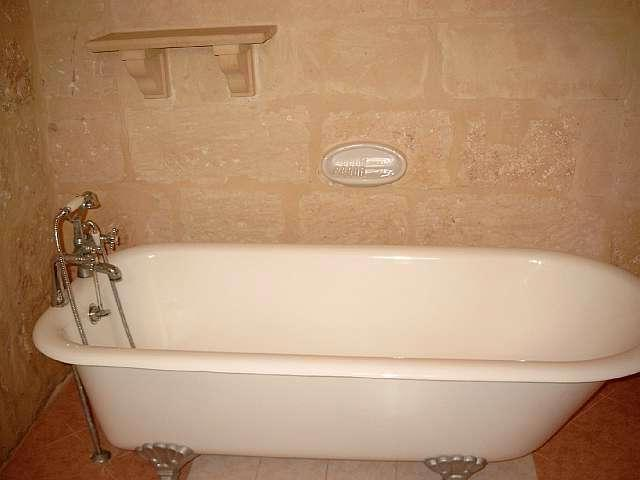

In [27]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [28]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - bathtub, probability - 0.8909816145896912


## 정리

endpoint 작업이 완료되면 이를 삭제하는데, 뒷단의 인스턴스들도 해제가 됩니다. endpoint를 삭제하기 위해 다음 셀을 실행하시기 바랍니다. 

In [29]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '543c291e-8aa9-483c-be47-906fd5504e30',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '543c291e-8aa9-483c-be47-906fd5504e30',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 04 Nov 2019 17:19:29 GMT'},
  'RetryAttempts': 0}}